In [ ]:
import numpy as np
import sys

In [ ]:
from misc import load, load_class_labels

dataset_root = "../dataset/"

train_dir = dataset_root + "train_set/"
val_dir = dataset_root + "val_set/"
val_degraded_dir = dataset_root + "val_set_degraded/"

sample_rate = 1
train_info = load(dataset_root + 'labels/train.csv', 1, sample_rate)
val_info = load(dataset_root + 'labels/validation.csv')
test_info = load(dataset_root + 'labels/test.csv')

train_image_names = train_info.iloc[:, 0].values
val_image_names = val_info.iloc[:, 0].values

train_labels = train_info.iloc[:, 1].values
val_labels = val_info.iloc[:, 1].values

class_labels = load_class_labels(dataset_root + 'classes.txt')

In [ ]:
from nn_filter import NN_filter

filter = NN_filter(train_info, train_dir, 'efficient_net', batch_size=25)

In [ ]:
features, labels, image_names = filter.fit_train()

## Extract validation from trainig set

In [ ]:
import pandas as pd
train_info = load(dataset_root + 'train_info_dirty.csv', 1, 0.8)
val_info = load(dataset_root + 'train_info_dirty.csv', 1, 1)


same = val_info['filename'].isin(train_info['filename'])
val_info.drop(val_info[same].index, inplace=True)

#train_info.to_csv(dataset_root + '/labels/train.csv', header=False, index=False);
#val_info.to_csv(dataset_root + '/labels/validation.csv', header=False, index=False);

## Outlier detection with NN features

In [223]:
# from image_discard import discard_preprocessing
def discard_preprocessing(dir, image_names, labels, bw_threshold=0.9, no_gradient_threshold=0.83, zero_threshold=0.6,
                          gradient_threshold=0.15, crop_size=0.4):
    from tqdm.notebook import tqdm_notebook
    import cv2 as cv
    discarded_images = [[] for _ in range(251)]
    discarded_indices = []

    for i, (image_name, c) in tqdm_notebook(enumerate(zip(image_names, labels))):
        color_image = cv.imread(dir + image_name)
        image = cv.cvtColor(color_image, cv.COLOR_BGR2GRAY)
        
        center = image.shape
        w = center[1] * crop_size
        h = center[0] * crop_size
        x = center[1] / 2 - w / 2
        y = center[0] / 2 - h / 2
        cropped = image[int(y):int(y + h), int(x):int(x + w)]
        
        flattened = cropped.flatten()
        flattened_mask = ((flattened <= 30) | (flattened >= 220))
        bw_proportion = len(flattened[flattened_mask]) / len(flattened)

        if bw_proportion > bw_threshold:
            discarded_images[c].append(image_name)
            discarded_indices.append(i)
            continue

        gradient = cv.Laplacian(cropped, 0).flatten()
        no_gradient_rate = len(gradient[abs(gradient) < 1].flatten()) / len(gradient)
        if no_gradient_rate >= no_gradient_threshold:
            discarded_images[c].append(image_name)
            discarded_indices.append(i)
            continue

        gradient_rate = len(gradient[abs(gradient) >= 130].flatten()) / len(gradient[abs(gradient) > 0].flatten())
        zero_rate = len(gradient[(abs(gradient) <= 0)].flatten()) / len(gradient.flatten())

        if gradient_rate >= gradient_threshold and zero_rate >= zero_threshold:
            discarded_images[c].append(image_name)
            discarded_indices.append(i)

    return discarded_images, discarded_indices

names, indices = discard_preprocessing(train_dir, train_image_names, train_labels)

0it [00:00, ?it/s]

In [226]:
count = 0
for c in names:
    count += len(c)
count

553

In [227]:
kept_indices = ~np.isin([i for i in range(len(train_image_names))], indices)

preprocessed_features = features[kept_indices]
preprocessed_train_names = train_image_names[kept_indices]
preprocessed_train_labels = train_labels[kept_indices]
preprocessed_train_info = pd.DataFrame({
    'filename': preprocessed_train_names,
    'label': preprocessed_train_labels
})

In [228]:
from image_discard import write_discarded_images
write_discarded_images(names, class_labels, dataset_root + "discarded_preprocess/", train_dir)

In [399]:
def find_outliers_median(features, labels, image_names, threshold=30):
    from sklearn.preprocessing import normalize
    classes = np.unique(labels)
    distances = [[] for _ in range(len(classes))]
    names = [[] for _ in range(len(classes))]
    for c in classes:
        indices = labels == c
        to_consider = features[indices]
        normalized = normalize(to_consider, axis=1)
        median = np.median(normalized, axis=0)

        for image, name in zip(normalized, image_names[indices]):
            # d1 = np.linalg.norm((image - median))
            # d1 = np.sum(np.abs(median - image))
            d1 = 1 - np.dot(image, median) / (np.linalg.norm(image) * np.linalg.norm(median))
            
            if d1 >= threshold:
                distances[c].append(d1)
                names[c].append(name)

        distances[c] = np.asarray(distances[c])
        names[c] = np.asarray(names[c])
        _sorted = np.argsort(distances[c])[::-1]
        distances[c] = distances[c][_sorted]
        names[c] = names[c][_sorted]
    return names, distances



def find_outliers_iter_median(features, labels, image_names, threshold=30, iter=10):
    to_consider = np.ones((len(features)))
    classes = np.unique(labels)
    distances = [[] for _ in range(len(classes))]
    names = [[] for _ in range(len(classes))]

    for _ in (range(iter)):
        features_to_consider = features[to_consider == 1]
        names_to_consider = image_names[to_consider == 1]
        labels_to_consider = labels[to_consider == 1]

        n, d = find_outliers_median(features_to_consider, labels_to_consider, names_to_consider,
                                    threshold)
        for i in range(len(n)):
            for j in range(len(d[i])):
                names[i].append(n[i][j])
                distances[i].append(d[i][j])
                to_consider[np.where(image_names == n[i][j])[0]] = 0

    return names, distances
names, distances = find_outliers_iter_median(preprocessed_features, preprocessed_train_labels, preprocessed_train_names, threshold=0.69, iter=1)

In [401]:
from image_discard import write_discarded_images, find_outliers_iter, write_cleaned_csv
write_discarded_images(names, class_labels, dataset_root + "discarded_scaling_features_efficientnetv2_median/", train_dir)

In [400]:
count = 0
for c in names:
    count += len(c)
count

13208

In [402]:
clean_train_info = write_cleaned_csv(preprocessed_train_info, names, dataset_root + "clean_efficientnet_v2/median/")

In [404]:
clean_names = clean_train_info.iloc[:, 0].values
clean_labels = clean_train_info.iloc[:, 1].values

kept_names = [[] for _ in range(251)]
for name, label in zip(clean_names, clean_labels):
    kept_names[label].append(name)

write_discarded_images(kept_names, class_labels, dataset_root + "kept_efficientnet_v2_median/", train_dir)

In [405]:
test_info[test_info['label'] == 116]

,filename,label
3711,val_001933.jpg,116
7423,val_005689.jpg,116


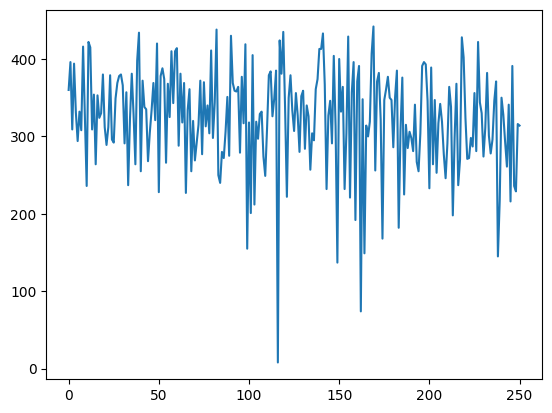

In [413]:
cardinalities = np.zeros(251)
for i in range(251):
    count = len(preprocessed_train_info[preprocessed_train_info['label'] == i])
    cardinalities[i] = count - len(names[i])
    
import matplotlib.pyplot as plt
plt.plot(cardinalities)